# Assignment Summary

**Denoising autoencoders**: We will evaluate denoising autoencoders applied to the MNIST dataset.

* Obtain (or write! but this isn't required) a pytorch/tensorflow/etc. code for a denoising autoencoder. Train this autoencoder on the MNIST dataset. Use only the MNIST training set. You should use at least three layers in the encoder and in the decoder.
* We now need to determine how well this autoencoder works. For each image in the MNIST test dataset, compute the residual error of the autoencoder. This is the difference between the true image and the reconstruction of that image by the autoencoder. It is an image itself. Prepare a figure showing the mean residual error, and the first five principal components. Each is an image. You should preserve signs (i.e. the mean residual error may have negative as well as positive entries). The way to show these images most informatively is to use a mid gray value for zero, then darker values for more negative image values and lighter values for more positive values. The scale you choose matters. You should show
    * mean and five principal components on the same gray scale for all six images, chosen so the largest absolute value over all six images is full dark or full light respectively and
    * mean and five principal components on a scale where the gray scale is chosen for each image separately.

**Variational autoencoders**: We will evaluate variational autoencoders applied to the MNIST dataset.
  * Obtain (or write! but this isn't required) a pytorch/tensorflow/etc. code for a variational autoencoder. Train this autoencoder on the MNIST dataset. Use only the MNIST training set.
  * We now need to determine how well the codes produced by this autoencoder can be interpolated.
    * For 10 pairs of MNIST test images of the same digit, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.
    * For 10 pairs of MNIST test images of different digits, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.

**Hints and References**: For the denoising autoencoder, there is an abundance of code online should you choose to obtain one. It may be a good practice to also implement this part from scratch and test what you learned in the CNN assignment. All you have to do is define a network with two groups of layers:
  * *Encoder Layers*: This part must take an image and produce a low-dimensional "code" of the image. Therefore, the architecture of the netwok must be narrowing down. Let's call this function $f^{\text{encoder}}$.
  * *Decoder Layers*: This part must take a low-dimensional "code" of the image and produce the original image. Therefore, the architecture of the netwok must be expanding. Let's call this function $f^{\text{decoder}}$.
  
All you have to do is to try and write some code to minimize the following loss:

$$\mathcal{L} = \frac{1}{N} \sum_{i=1}^N \|x_i - f^{\text{decoder}}(f^{\text{encoder}}(x_i))\|_2^2$$

You may pick any architecture that works as long as it has three layes. The MNIST data has 784 pixels. Therefore, a fully connected network which takes 784 reshaped dimensions to $h_1$ dimensions, then to $h_2$ dimensions, and finally to $h_3$ dimensions is an excellent starting point for an encoder. A vast range of choices can work for these three numbers, but just to give you an idea about their plausible range of values, $h_1$ could be in the order of hundreds, $h_2$ could be in order of tens (or at most a few hundreds), and $h_3$ is supposed to be a low-dimension (preferrably under 10 or at most 20).

You can reverse the encoder architecture, to obtain a decoder, and then stack an SGD optimizer on top with default hyper-parameters to train your denoising autoencoder. You must be familiar with the rest of the concepts from earlier assignments such as multi-dimensional scalings and PCA. You also would need to write some basic code to visualize using matplotlib, PIL, etc.

For VAEs, you may also be able to implement everything from scratch once you review the material. However, there are a lot of resources and examples for implementing VAEs, and here we share a few of them:

  1. Pytorch Tutorials has an example for training VAEs at https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py
  2. Another pytorch example for VAEs can be found at https://github.com/pytorch/examples/blob/master/vae/main.py
  3. Pyro is a library for bayesian optimization and is based on pytorch, which has a detailed tutorial on how to train VAEs with some high-level story of the math involved https://pyro.ai/examples/vae.html
  4. BoTorch is another bayesian optimization library based based on pytorch and has some tutorials for implementing VAEs https://botorch.org/tutorials/vae_mnist
  5. If you're a tensorflow fan, you may find some tutorial at https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE or  https://www.tensorflow.org/tutorials/generative/cvae
  6. Keras fans can also see https://keras.io/examples/generative/vae/
  7. etc.
  
The MNIST data is provided at `../VAE-lib/data_mnist` so that you could use the `torchvision` API for loading the data just like the previous assignment.

**Important Note**: This assignment will not be automatically graded and is optional. Therefore, do not expect meaninful grades to be published upon or after submission. However, please make sure to submit your work if you expect it to be reviewed by the instructors for any reason. We will consider the latest submission of your work. 

Any work that is not submitted will not be viewed by us.

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import torch
import botorch
import pyro
import matplotlib.pyplot as plt

# Denoising autoencoders

In [2]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

In [3]:

# Load the dataset, add gaussian,poisson,speckle
'''

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.

'''
    
# Define a function that adds each noise when called from main function

def add_noise(img,noise_type="gaussian"):
  
  row,col=28,28
  img=img.astype(np.float32)
  
  if noise_type=="gaussian":
    mean=0
    var=10
    sigma=var**.5
    noise=np.random.normal(-5.9,5.9,img.shape)
    noise=noise.reshape(row,col)
    img=img+noise
    return img

  if noise_type=="speckle":
    noise=np.random.randn(row,col)
    noise=noise.reshape(row,col)
    img=img+img*noise
    return img

In [4]:
# Load the dataset from keras
(xtrain,ytrain),(xtest,ytest)=mnist.load_data()
print("Train dataset:{}\nTest dataset:{}".format(len(xtrain),len(xtest)))

Train dataset:60000
Test dataset:10000


In [5]:
# Split the 60k train dataset into 3 sets each given one type of each noise.
# Shuffle for better generalization
# https://sofiadutta.github.io/datascience-ipynbs/pytorch/Denoising-Autoencoder.html
# https://www.analyticsvidhya.com/blog/2021/07/image-denoising-using-autoencoders-a-beginners-guide-to-deep-learning-project/
# https://medium.com/@connectwithghosh/denoising-images-using-an-autoencoder-using-tensorflow-in-python-1e2e62932837
# https://medium.com/@connectwithghosh/simple-autoencoder-example-using-tensorflow-in-python-on-the-fashion-mnist-dataset-eee63b8ed9f1


noises=["gaussian","speckle"]
noise_ct=0
noise_id=0
traindata=np.zeros((60000,28,28))

for idx in tqdm(range(len(xtrain))):
  
  if noise_ct<(len(xtrain)/2):
    noise_ct+=1
    traindata[idx]=add_noise(xtrain[idx],noise_type=noises[noise_id])
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0

print("\n{} noise addition completed to images".format(noises[noise_id])) 


noise_ct=0
noise_id=0
testdata=np.zeros((10000,28,28))

for idx in tqdm(range(len(xtest))):
  
  if noise_ct<(len(xtest)/2):
    noise_ct+=1
    x=add_noise(xtest[idx],noise_type=noises[noise_id])
    testdata[idx]=x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id]))    

 58%|█████▊    | 34726/60000 [00:01<00:00, 28389.42it/s]


gaussian noise addition completed to images


 29%|██▉       | 2905/10000 [00:00<00:00, 29040.82it/s]


speckle noise addition completed to images

gaussian noise addition completed to images


100%|██████████| 10000/10000 [00:00<00:00, 29334.00it/s]


speckle noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

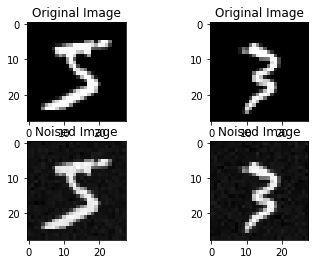

In [6]:
# visualize the noisy images along with their original versions

f, axes=plt.subplots(2,2)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0],cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0],cmap='gray')
axes[1,0].set_title("Noised Image")

#showing images with speckle noise
axes[0,1].imshow(xtrain[25000],cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[25000],cmap="gray")
axes[1,1].set_title("Noised Image")

In [7]:
# Create dataset which includes both clean and noisy images


class noisedDataset(Dataset):
  
  def __init__(self,datasetnoised,datasetclean,labels,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    self.labels=labels
    self.transform=transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    y=self.labels[idx]
    
    if self.transform != None:
      xNoise=self.transform(xNoise)
      xClean=self.transform(xClean)
      
    
    return (xNoise,xClean,y)

In [8]:
tsfms=transforms.Compose([
    transforms.ToTensor()
])

trainset=noisedDataset(traindata,xtrain,ytrain,tsfms)
testset=noisedDataset(testdata,xtest,ytest,tsfms)

In [9]:
# Create the trainloaders and testloaders.
# Transform the images using standard lib functions

batch_size=32

trainloader=DataLoader(trainset,batch_size=32,shuffle=True)
testloader=DataLoader(testset,batch_size=1,shuffle=True)

In [10]:
# Define the autoencoder model.


class denoising_model(nn.Module):
  def __init__(self):
    super(denoising_model,self).__init__()
    self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
        
                  )
    
    self.decoder=nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
 
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    
    return x

In [11]:
# Check whether cuda is available and choose device accordingly
if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

  
model=denoising_model().to(device)
criterion=nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)


epochs=120
l=len(trainloader)
losslist=list()
epochloss=0
running_loss=0
for epoch in range(epochs):
  
  print("Entering Epoch: ",epoch)
  for dirty,clean,label in tqdm((trainloader)):
    
    
    dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
    clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
    dirty,clean=dirty.to(device),clean.to(device)
    
    #Forward Pass
    output=model(dirty)
    loss=criterion(output,clean)
    #Backward Pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss+=loss.item()
    epochloss+=loss.item()
  #Log
  losslist.append(running_loss/l)
  running_loss=0
                
print('Finished Training')

  2%|▏         | 31/1875 [00:00<00:06, 301.42it/s]

Entering Epoch:  0


  2%|▏         | 33/1875 [00:00<00:05, 323.92it/s]

Entering Epoch:  1


  2%|▏         | 32/1875 [00:00<00:05, 317.38it/s]

Entering Epoch:  2


  2%|▏         | 32/1875 [00:00<00:05, 319.43it/s]

Entering Epoch:  3


  2%|▏         | 32/1875 [00:00<00:05, 317.70it/s]

Entering Epoch:  4


  2%|▏         | 32/1875 [00:00<00:05, 315.46it/s]

Entering Epoch:  5


  2%|▏         | 32/1875 [00:00<00:05, 310.56it/s]

Entering Epoch:  6


  2%|▏         | 32/1875 [00:00<00:05, 308.95it/s]

Entering Epoch:  7


  2%|▏         | 33/1875 [00:00<00:05, 320.61it/s]

Entering Epoch:  8


  2%|▏         | 33/1875 [00:00<00:05, 318.77it/s]

Entering Epoch:  9


  2%|▏         | 30/1875 [00:00<00:06, 296.20it/s]

Entering Epoch:  10


  2%|▏         | 30/1875 [00:00<00:06, 298.82it/s]

Entering Epoch:  11


  1%|          | 23/1875 [00:00<00:08, 229.61it/s]

Entering Epoch:  12


  1%|          | 23/1875 [00:00<00:08, 223.92it/s]

Entering Epoch:  13


  2%|▏         | 29/1875 [00:00<00:06, 288.83it/s]

Entering Epoch:  14


  2%|▏         | 30/1875 [00:00<00:06, 292.39it/s]

Entering Epoch:  15


  2%|▏         | 29/1875 [00:00<00:06, 281.83it/s]

Entering Epoch:  16


  2%|▏         | 29/1875 [00:00<00:06, 288.06it/s]

Entering Epoch:  17


  2%|▏         | 29/1875 [00:00<00:06, 285.25it/s]

Entering Epoch:  18


  2%|▏         | 29/1875 [00:00<00:06, 288.26it/s]

Entering Epoch:  19


  2%|▏         | 29/1875 [00:00<00:06, 281.56it/s]

Entering Epoch:  20


  2%|▏         | 29/1875 [00:00<00:06, 280.86it/s]

Entering Epoch:  21


  2%|▏         | 30/1875 [00:00<00:06, 291.04it/s]

Entering Epoch:  22


  2%|▏         | 29/1875 [00:00<00:06, 282.58it/s]

Entering Epoch:  23


  1%|          | 23/1875 [00:00<00:08, 224.58it/s]

Entering Epoch:  24


  2%|▏         | 29/1875 [00:00<00:06, 281.99it/s]

Entering Epoch:  25


  2%|▏         | 29/1875 [00:00<00:06, 288.21it/s]

Entering Epoch:  26


  2%|▏         | 29/1875 [00:00<00:06, 280.55it/s]

Entering Epoch:  27


  1%|▏         | 28/1875 [00:00<00:06, 274.28it/s]

Entering Epoch:  28


  1%|▏         | 27/1875 [00:00<00:07, 261.56it/s]

Entering Epoch:  29


  1%|▏         | 28/1875 [00:00<00:06, 270.95it/s]

Entering Epoch:  30


  1%|▏         | 28/1875 [00:00<00:06, 274.04it/s]

Entering Epoch:  31


  1%|▏         | 28/1875 [00:00<00:06, 272.00it/s]

Entering Epoch:  32


  1%|▏         | 28/1875 [00:00<00:06, 270.93it/s]

Entering Epoch:  33


  1%|▏         | 27/1875 [00:00<00:06, 267.08it/s]

Entering Epoch:  34


  1%|▏         | 28/1875 [00:00<00:06, 275.36it/s]

Entering Epoch:  35


  1%|▏         | 27/1875 [00:00<00:06, 266.91it/s]

Entering Epoch:  36


  1%|▏         | 28/1875 [00:00<00:06, 271.15it/s]

Entering Epoch:  37


  1%|▏         | 28/1875 [00:00<00:06, 272.72it/s]

Entering Epoch:  38


  1%|▏         | 28/1875 [00:00<00:06, 271.17it/s]

Entering Epoch:  39


  1%|▏         | 24/1875 [00:00<00:07, 236.29it/s]

Entering Epoch:  40


  1%|▏         | 27/1875 [00:00<00:06, 269.76it/s]

Entering Epoch:  41


  1%|▏         | 27/1875 [00:00<00:07, 260.87it/s]

Entering Epoch:  42


  1%|▏         | 27/1875 [00:00<00:06, 266.98it/s]

Entering Epoch:  43


  1%|▏         | 28/1875 [00:00<00:06, 271.23it/s]

Entering Epoch:  44


  1%|▏         | 27/1875 [00:00<00:06, 267.33it/s]

Entering Epoch:  45


  1%|▏         | 28/1875 [00:00<00:06, 274.51it/s]

Entering Epoch:  46


  1%|▏         | 27/1875 [00:00<00:06, 269.74it/s]

Entering Epoch:  47


  1%|▏         | 26/1875 [00:00<00:07, 251.80it/s]

Entering Epoch:  48


  1%|▏         | 28/1875 [00:00<00:06, 274.70it/s]

Entering Epoch:  49


  1%|▏         | 28/1875 [00:00<00:06, 273.78it/s]

Entering Epoch:  50


  1%|▏         | 27/1875 [00:00<00:07, 263.47it/s]

Entering Epoch:  51


  1%|▏         | 27/1875 [00:00<00:06, 267.39it/s]

Entering Epoch:  52


  1%|▏         | 27/1875 [00:00<00:07, 263.94it/s]

Entering Epoch:  53


  1%|▏         | 28/1875 [00:00<00:06, 264.78it/s]

Entering Epoch:  54


  1%|▏         | 27/1875 [00:00<00:06, 265.55it/s]

Entering Epoch:  55


  1%|▏         | 28/1875 [00:00<00:06, 272.81it/s]

Entering Epoch:  56


  1%|▏         | 27/1875 [00:00<00:06, 269.09it/s]

Entering Epoch:  57


  2%|▏         | 29/1875 [00:00<00:06, 277.76it/s]

Entering Epoch:  58


  2%|▏         | 29/1875 [00:00<00:06, 287.17it/s]

Entering Epoch:  59


  2%|▏         | 29/1875 [00:00<00:06, 275.57it/s]

Entering Epoch:  60


  1%|▏         | 24/1875 [00:00<00:07, 236.47it/s]

Entering Epoch:  61


  1%|▏         | 24/1875 [00:00<00:07, 231.63it/s]

Entering Epoch:  62


  2%|▏         | 29/1875 [00:00<00:06, 284.82it/s]

Entering Epoch:  63


  2%|▏         | 29/1875 [00:00<00:06, 286.05it/s]

Entering Epoch:  64


  2%|▏         | 30/1875 [00:00<00:06, 295.71it/s]

Entering Epoch:  65


  2%|▏         | 29/1875 [00:00<00:06, 281.89it/s]

Entering Epoch:  66


  2%|▏         | 29/1875 [00:00<00:06, 289.44it/s]

Entering Epoch:  67


  2%|▏         | 30/1875 [00:00<00:06, 298.40it/s]

Entering Epoch:  68


  2%|▏         | 30/1875 [00:00<00:06, 294.50it/s]

Entering Epoch:  69


  2%|▏         | 30/1875 [00:00<00:06, 294.77it/s]

Entering Epoch:  70


  2%|▏         | 30/1875 [00:00<00:06, 292.22it/s]

Entering Epoch:  71


  2%|▏         | 30/1875 [00:00<00:06, 295.45it/s]

Entering Epoch:  72


  2%|▏         | 30/1875 [00:00<00:06, 289.63it/s]

Entering Epoch:  73


  2%|▏         | 29/1875 [00:00<00:06, 288.21it/s]

Entering Epoch:  74


  2%|▏         | 30/1875 [00:00<00:06, 293.35it/s]

Entering Epoch:  75


  2%|▏         | 30/1875 [00:00<00:06, 295.56it/s]

Entering Epoch:  76


  2%|▏         | 30/1875 [00:00<00:06, 294.17it/s]

Entering Epoch:  77


  2%|▏         | 30/1875 [00:00<00:06, 293.44it/s]

Entering Epoch:  78


  2%|▏         | 30/1875 [00:00<00:06, 297.65it/s]

Entering Epoch:  79


  2%|▏         | 30/1875 [00:00<00:06, 291.78it/s]

Entering Epoch:  80


  2%|▏         | 30/1875 [00:00<00:06, 297.82it/s]

Entering Epoch:  81


  2%|▏         | 30/1875 [00:00<00:06, 289.06it/s]

Entering Epoch:  82


  2%|▏         | 31/1875 [00:00<00:06, 301.28it/s]

Entering Epoch:  83


  2%|▏         | 30/1875 [00:00<00:06, 297.50it/s]

Entering Epoch:  84


  2%|▏         | 29/1875 [00:00<00:06, 286.55it/s]

Entering Epoch:  85


  2%|▏         | 30/1875 [00:00<00:06, 297.06it/s]

Entering Epoch:  86


  2%|▏         | 30/1875 [00:00<00:06, 293.09it/s]

Entering Epoch:  87


  2%|▏         | 30/1875 [00:00<00:06, 296.94it/s]

Entering Epoch:  88


  2%|▏         | 30/1875 [00:00<00:06, 292.49it/s]

Entering Epoch:  89


  2%|▏         | 30/1875 [00:00<00:06, 295.59it/s]

Entering Epoch:  90


  2%|▏         | 31/1875 [00:00<00:06, 298.30it/s]

Entering Epoch:  91


  2%|▏         | 31/1875 [00:00<00:06, 302.27it/s]

Entering Epoch:  92


  2%|▏         | 30/1875 [00:00<00:06, 292.63it/s]

Entering Epoch:  93


  2%|▏         | 30/1875 [00:00<00:06, 297.35it/s]

Entering Epoch:  94


  2%|▏         | 31/1875 [00:00<00:06, 302.76it/s]

Entering Epoch:  95


  2%|▏         | 30/1875 [00:00<00:06, 294.49it/s]

Entering Epoch:  96


  2%|▏         | 30/1875 [00:00<00:06, 296.99it/s]

Entering Epoch:  97


  2%|▏         | 29/1875 [00:00<00:06, 287.68it/s]

Entering Epoch:  98


  2%|▏         | 30/1875 [00:00<00:06, 294.08it/s]

Entering Epoch:  99


  2%|▏         | 30/1875 [00:00<00:06, 296.22it/s]

Entering Epoch:  100


  2%|▏         | 31/1875 [00:00<00:06, 306.71it/s]

Entering Epoch:  101


  2%|▏         | 30/1875 [00:00<00:06, 299.48it/s]

Entering Epoch:  102


  2%|▏         | 31/1875 [00:00<00:06, 302.73it/s]

Entering Epoch:  103


  2%|▏         | 30/1875 [00:00<00:06, 295.19it/s]

Entering Epoch:  104


  2%|▏         | 30/1875 [00:00<00:06, 298.39it/s]

Entering Epoch:  105


  1%|▏         | 24/1875 [00:00<00:08, 229.72it/s]

Entering Epoch:  106


  2%|▏         | 30/1875 [00:00<00:06, 293.29it/s]

Entering Epoch:  107


  2%|▏         | 31/1875 [00:00<00:06, 302.94it/s]

Entering Epoch:  108


  2%|▏         | 31/1875 [00:00<00:06, 300.18it/s]

Entering Epoch:  109


  2%|▏         | 30/1875 [00:00<00:06, 299.11it/s]

Entering Epoch:  110


  2%|▏         | 31/1875 [00:00<00:06, 303.73it/s]

Entering Epoch:  111


  2%|▏         | 31/1875 [00:00<00:06, 301.93it/s]

Entering Epoch:  112


  2%|▏         | 30/1875 [00:00<00:06, 298.92it/s]

Entering Epoch:  113


  1%|▏         | 25/1875 [00:00<00:07, 242.90it/s]

Entering Epoch:  114


  2%|▏         | 31/1875 [00:00<00:06, 302.77it/s]

Entering Epoch:  115


  2%|▏         | 30/1875 [00:00<00:06, 299.02it/s]

Entering Epoch:  116


  2%|▏         | 31/1875 [00:00<00:06, 302.60it/s]

Entering Epoch:  117


  2%|▏         | 31/1875 [00:00<00:06, 307.02it/s]

Entering Epoch:  118


  2%|▏         | 30/1875 [00:00<00:06, 298.00it/s]

Entering Epoch:  119


100%|██████████| 1875/1875 [00:06<00:00, 307.42it/s]

Finished Training


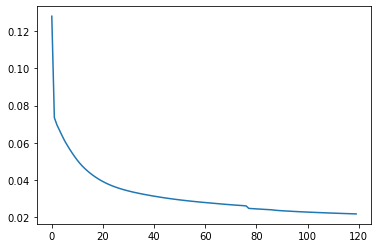

In [12]:
plt.plot(range(len(losslist)),losslist)

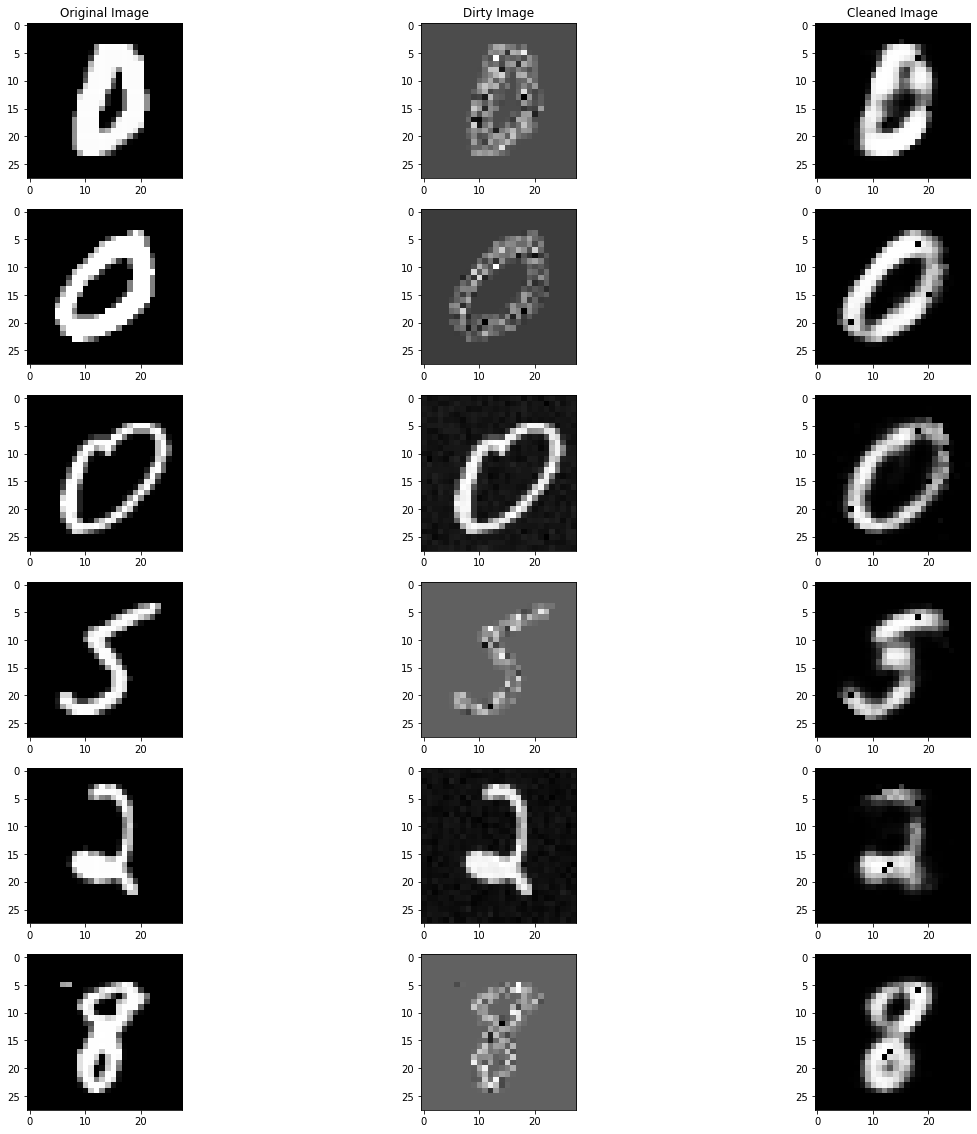

In [13]:

# Visualize some of the results
# Randomly generate 6 numbers in between 1 and 10k, run them through the model, and show the results with comparisons


f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,10000,size=6)
for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)
  output=model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")
  

# Variational autoencoders

In [14]:
import torch
torch.rand(5, 3)

tensor([[0.3139, 0.9634, 0.8409],
        [0.9595, 0.9727, 0.3017],
        [0.9493, 0.3110, 0.4149],
        [0.4082, 0.2987, 0.9905],
        [0.1689, 0.9509, 0.6728]])

In [15]:
# Load dataset

from torchvision import datasets, transforms

root = '../VAE-lib/data_mnist'

transformations = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root = root, train = True, download = True, transform = transformations)
mnist_test = datasets.MNIST(root = root, train = False, download = True, transform = transformations)

In [16]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle=True)

In [17]:
from torch import nn
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
    
        self.fc1 = nn.Linear(784, 400)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim) 
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        h3 = self.relu(self.fc3(x))
        return self.sigmoid(self.fc4(h3))

In [18]:
def sample(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    
    return mu + eps*std

In [19]:
def vae_loss(x, x_hat, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [20]:
from torch import optim
latent_dim = 32
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)

In [21]:
def train(encoder, decoder, train_loader, optimizer, num_epochs = 10):
    encoder.train()
    decoder.train()
    
    for epoch in range(num_epochs):
        train_loss = 0
        for i, (batch_data, batch_target) in enumerate(train_loader):

            optimizer.zero_grad()
            
            mu, logvar = encoder.forward(batch_data.view(-1, 784))
            
            latent_vector = sample(mu, logvar)
            
            recon_batch = decoder.forward(latent_vector)
            batch_loss = vae_loss(batch_data, recon_batch, mu, logvar)
            
            batch_loss.backward()
            train_loss += batch_loss.item()
            optimizer.step()
        print('Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    return


In [22]:
train(encoder, decoder, train_loader, optimizer, num_epochs = 10)

Epoch: 0 Average loss: 139.0769
Epoch: 1 Average loss: 114.3708
Epoch: 2 Average loss: 110.4750
Epoch: 3 Average loss: 108.7766
Epoch: 4 Average loss: 107.7789
Epoch: 5 Average loss: 107.1346
Epoch: 6 Average loss: 106.5925
Epoch: 7 Average loss: 106.1693
Epoch: 8 Average loss: 105.8851
Epoch: 9 Average loss: 105.6212


In [23]:
import matplotlib.pyplot as plt
from torchvision import utils
%matplotlib inline
import numpy as np

In [24]:
def create_interpolates(A, B, encoder, decoder):
    A_mu, A_logvar = encoder.forward(A.view(-1, 784))
    A_latent_vector = sample(A_mu, A_logvar)
    B_mu, B_logvar = encoder.forward(B.view(-1, 784))
    B_latent_vector = sample(B_mu, B_logvar)
    
    A_array = A_latent_vector.detach().numpy()
    B_array = B_latent_vector.detach().numpy()
    
    total_array = np.zeros((9, latent_dim))
    total_array[0] = A_array[0]
    total_array[8] = B_array[0]

    for i in range(1, 8):
        for j in range(latent_dim):
            
            space = (A_array[0][j] - B_array[0][j]) / 8
            total_array[i, j] = A_array[0][j] - space * i
    
    interpolation = []
    
    interpolation.append(decoder.forward(A_latent_vector))

    for i in range(1, 8):
        curr_tensor = torch.from_numpy(total_array[i]).float()
        interpolation.append(decoder.forward(curr_tensor))
    interpolation.append(decoder.forward(B_latent_vector))
    
    return interpolation

In [25]:
similar_pairs = {}

for _, (x, y) in enumerate(test_loader):
    for i in range(len(y)):
        if y[i].item() not in similar_pairs:
            similar_pairs[y[i].item()] = []
        if len(similar_pairs[y[i].item()])<2:
            similar_pairs[y[i].item()].append(x[i])
  
    done = True
    for i in range(10):
        if i not in similar_pairs or len(similar_pairs[i])<2:
            done = False
  
    if done:
        break
        

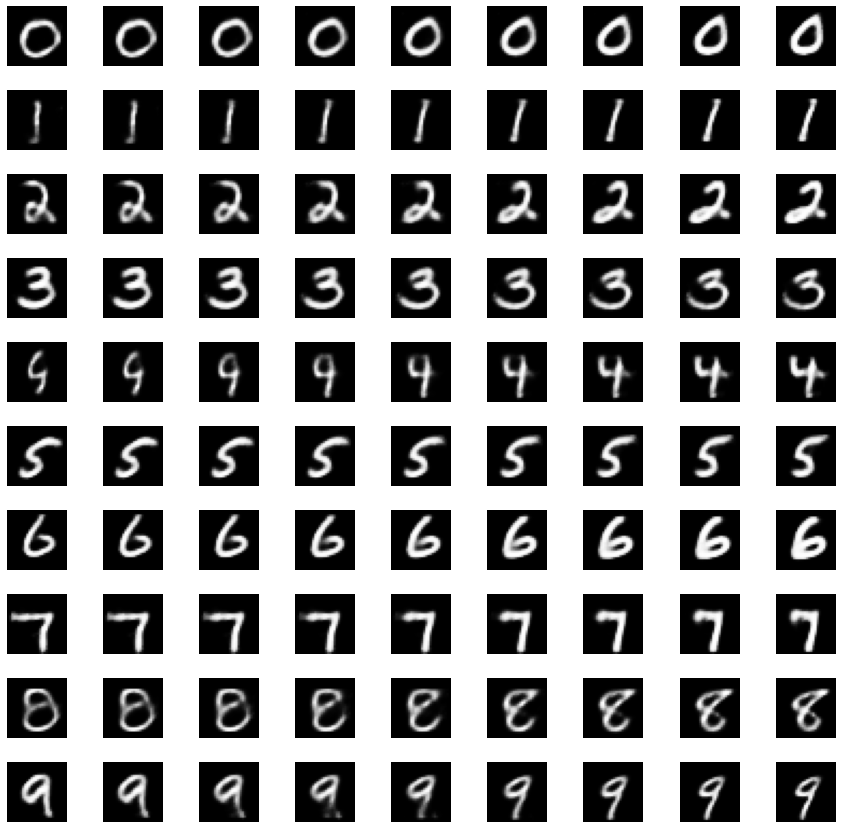

In [26]:
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(0, 10):
    curr_interp = create_interpolates(similar_pairs[i][0], similar_pairs[i][1], encoder, decoder)
    for j in range(0, 9):
        curr_plot = curr_interp[j].detach().numpy()
        curr_plot = curr_plot.reshape((28, 28))
        
        ax = fig.add_subplot(10, 9, (i * 9) + j + 1)
        ax.set_axis_off()
        plt.imshow(curr_plot, cmap='gray')

plt.show()

In [27]:
random_pairs = {}

for _, (x, y) in enumerate(test_loader):
    for i in range(10):
        random_pairs[i] = []
        random_pairs[i].append(x[2*i])
        random_pairs[i].append(x[2*i+1])
    break

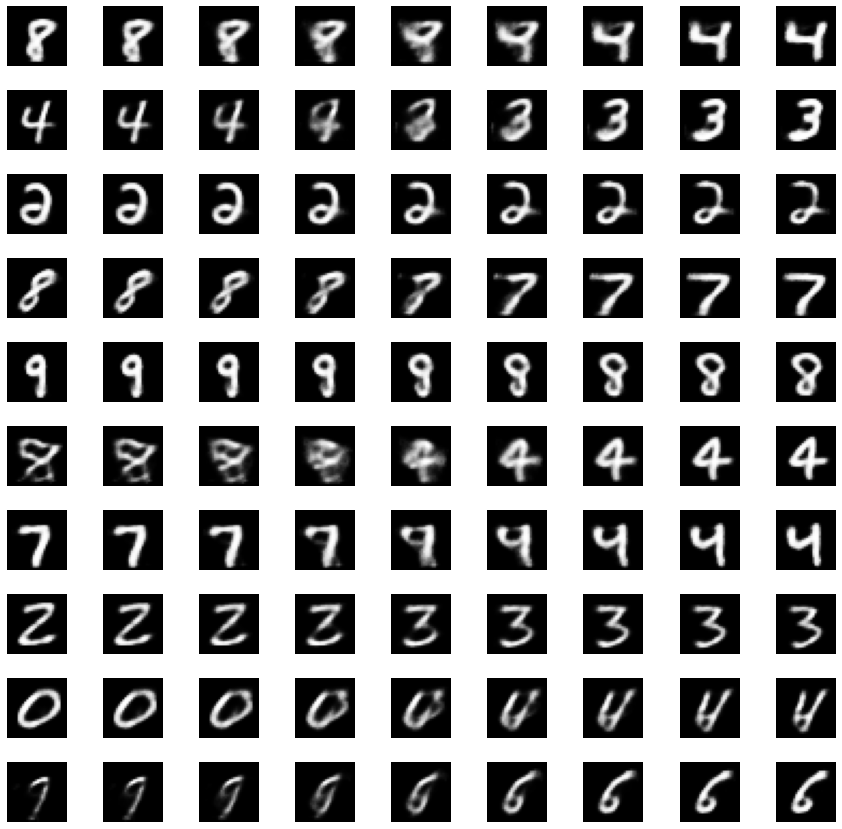

In [28]:
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(0, 10):
    curr_interp = create_interpolates(random_pairs[i][0], random_pairs[i][1], encoder, decoder)
    for j in range(0, 9):
        curr_plot = curr_interp[j].detach().numpy()
        curr_plot = curr_plot.reshape((28, 28))
        # curr_plot = np.expand_dims(curr_plot, axis=0)
        
        ax = fig.add_subplot(10, 9, (i * 9) + j + 1)
        ax.set_axis_off()
        plt.imshow(curr_plot, cmap='gray')

plt.show()
